In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Data Import

In [427]:
import pandas as pd

url = "https://raw.githubusercontent.com/Krishna941992/AI-ML/main/cars_sampled.csv"
df = pd.read_csv(url)

print(df.head())

        dateCrawled                                               name  \
0  30/03/2016 13:51                                       Zu_verkaufen   
1  07/03/2016 09:54                             Volvo_XC90_2.4D_Summum   
2  01/04/2016 00:57                                  Volkswagen_Touran   
3  19/03/2016 17:50                       Seat_Ibiza_1.4_16V_Reference   
4  16/03/2016 14:51  Volvo_XC90_D5_Aut._RDesign_R_Design_AWD_GSHD_S...   

    seller offerType  price   abtest vehicleType  yearOfRegistration  \
0  private     offer   4450     test   limousine                2003   
1  private     offer  13299  control         suv                2005   
2  private     offer   3200     test         bus                2003   
3  private     offer   4500  control   small car                2006   
4  private     offer  18750     test         suv                2008   

     gearbox  powerPS     model  kilometer  monthOfRegistration fuelType  \
0     manual      150       3er     150000    

In [367]:
# df = pd.read_csv("cars_sampled.csv")  # Replace with your actual file name

In [368]:
df.head(5)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
0,30/03/2016 13:51,Zu_verkaufen,private,offer,4450,test,limousine,2003,manual,150,3er,150000,3,diesel,bmw,NaN,30/03/2016 00:00,20257,07/04/2016 04:44
1,07/03/2016 09:54,Volvo_XC90_2.4D_Summum,private,offer,13299,control,suv,2005,manual,163,xc_reihe,150000,6,diesel,volvo,no,07/03/2016 00:00,88045,26/03/2016 13:17
2,01/04/2016 00:57,Volkswagen_Touran,private,offer,3200,test,bus,2003,manual,101,touran,150000,11,diesel,volkswagen,NaN,31/03/2016 00:00,27449,01/04/2016 08:40
3,19/03/2016 17:50,Seat_Ibiza_1.4_16V_Reference,private,offer,4500,control,small car,2006,manual,86,ibiza,60000,12,petrol,seat,no,19/03/2016 00:00,34537,07/04/2016 04:44
4,16/03/2016 14:51,Volvo_XC90_D5_Aut._RDesign_R_Design_AWD_GSHD_S...,private,offer,18750,test,suv,2008,automatic,185,xc_reihe,150000,11,diesel,volvo,no,16/03/2016 00:00,55270,01/04/2016 23:18


# Data Cleaning and Preprocessing

In [369]:
df.drop(columns=['name', 'seller', 'postalCode', 'dateCrawled', 'dateCreated', 'lastSeen','offerType'], inplace=True)

In [370]:
# Remove 0 or unrealistic prices
df = df[df['price'] > 100]

# Remove invalid power values
df = df[df['powerPS'] > 10]

# Filter registration years
df = df[(df['yearOfRegistration'] >= 1930) & (df['yearOfRegistration'] <= 2023)]

In [371]:
df.head(5)

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,4450,test,limousine,2003,manual,150,3er,150000,3,diesel,bmw,NaN
1,13299,control,suv,2005,manual,163,xc_reihe,150000,6,diesel,volvo,no
2,3200,test,bus,2003,manual,101,touran,150000,11,diesel,volkswagen,NaN
3,4500,control,small car,2006,manual,86,ibiza,60000,12,petrol,seat,no
4,18750,test,suv,2008,automatic,185,xc_reihe,150000,11,diesel,volvo,no


# Missing values handling

In [372]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
print(missing[missing > 0])
print("----Percentage missing----")
print(missing_percent[missing_percent > 0])

vehicleType          2869
gearbox               799
model                1698
fuelType             2606
notRepairedDamage    6294
dtype: int64
----Percentage missing----
vehicleType           6.639974
gearbox               1.849195
model                 3.929828
fuelType              6.031291
notRepairedDamage    14.566747
dtype: float64


In [373]:
print(df['vehicleType'].mode()[0])

#If I replace with limousine for all vehicle types that becomes bias in the data.
# So I choose group the data and then replace the missing values to correctly impute
# the values for better data input to model.

limousine


This function helps to replace values based on grouping selection.

In [374]:
# Function to impute using group-wise mode
def impute_with_group_mode(df, target_col, group_cols):
    mode_series = (
        df.groupby(group_cols)[target_col]
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        .reset_index()
        .rename(columns={target_col: f'{target_col}_mode'})
    )

    df = df.merge(mode_series, on=group_cols, how='left')
    df[target_col] = df[target_col].fillna(df[f'{target_col}_mode'])
    df.drop(columns=[f'{target_col}_mode'], inplace=True)
    return df

Handle the Model missings first as this downstreams to vehicleType

In [375]:
# Grouped mode imputation of model based on brand
df = impute_with_group_mode(df, 'model', ['brand'])

In [376]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
print(missing[missing > 0])
print("----Percentage missing----")
print(missing_percent[missing_percent > 0])

vehicleType          2869
gearbox               799
model                 314
fuelType             2606
notRepairedDamage    6294
dtype: int64
----Percentage missing----
vehicleType           6.639974
gearbox               1.849195
model                 0.726717
fuelType              6.031291
notRepairedDamage    14.566747
dtype: float64


Replacing missing values at brand and model level instead of simple mode.

In [377]:
df = impute_with_group_mode(df, target_col='vehicleType', group_cols=['brand', 'model'])

In [378]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
print(missing[missing > 0])
print("----Percentage missing----")
print(missing_percent[missing_percent > 0])

vehicleType            15
gearbox               799
model                 314
fuelType             2606
notRepairedDamage    6294
dtype: int64
----Percentage missing----
vehicleType           0.034716
gearbox               1.849195
model                 0.726717
fuelType              6.031291
notRepairedDamage    14.566747
dtype: float64


Replacing missing values at brand level as model have some nulls mode.

Brand with Others value cannot be intrepreted, so dropping 1% of the rows from brand = others

In [379]:
df = df[df['brand'].str.lower() != 'others']

In [380]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
print(missing[missing > 0])
print("----Percentage missing----")
print(missing_percent[missing_percent > 0])

gearbox               787
fuelType             2590
notRepairedDamage    6260
dtype: int64
----Percentage missing----
gearbox               1.834755
fuelType              6.038141
notRepairedDamage    14.594116
dtype: float64


In [381]:
df = impute_with_group_mode(df, target_col='vehicleType', group_cols=['brand', 'model'])

In [382]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
print(missing[missing > 0])
print("----Percentage missing----")
print(missing_percent[missing_percent > 0])

gearbox               787
fuelType             2590
notRepairedDamage    6260
dtype: int64
----Percentage missing----
gearbox               1.834755
fuelType              6.038141
notRepairedDamage    14.594116
dtype: float64


In [383]:
df['notRepairedDamage'] = df['notRepairedDamage'].fillna('unknown')

In [384]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
print(missing[missing > 0])
print("----Percentage missing----")
print(missing_percent[missing_percent > 0])

gearbox      787
fuelType    2590
dtype: int64
----Percentage missing----
gearbox     1.834755
fuelType    6.038141
dtype: float64


In [385]:
df['gearbox'] = df['gearbox'].fillna(df['gearbox'].mode()[0])

In [386]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
print(missing[missing > 0])
print("----Percentage missing----")
print(missing_percent[missing_percent > 0])

fuelType    2590
dtype: int64
----Percentage missing----
fuelType    6.038141
dtype: float64


In [387]:
df = impute_with_group_mode(df, 'fuelType', ['brand', 'vehicleType'])

In [388]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
print(missing[missing > 0])
print("----Percentage missing----")
print(missing_percent[missing_percent > 0])

fuelType    1
dtype: int64
----Percentage missing----
fuelType    0.002331
dtype: float64


In [389]:
df['fuelType'] = df['fuelType'].fillna(df['fuelType'].mode()[0])

In [390]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
print(missing[missing > 0])
print("----Percentage missing----")
print(missing_percent[missing_percent > 0])

Series([], dtype: int64)
----Percentage missing----
Series([], dtype: float64)


## Outlier handling

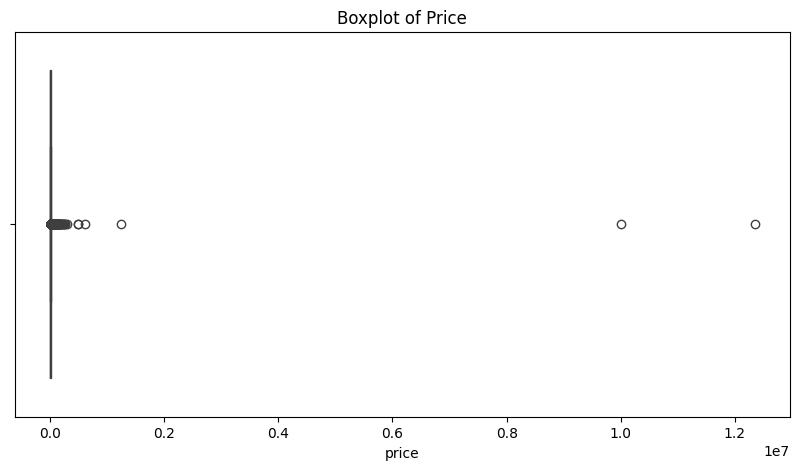

In [391]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['price'])
plt.title('Boxplot of Price')
plt.show()


In [392]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Upper and lower bound (1.5 * IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Upper bound: {upper_bound:.0f}")
print(f"lower_bound: {lower_bound:.0f}")

Upper bound: 17575
lower_bound: -8225


In [393]:
outliers = df[(df['price'] >= upper_bound)]
extreme_outliers = outliers.sort_values(by='price', ascending=False).head(2)
print(extreme_outliers[['brand', 'model', 'price']])

         brand  model     price
41650     ford  focus  12345678
15171  porsche    911   9999999


In [394]:
# Filter unrealistic extreme values
df = df[~df.index.isin(extreme_outliers.index)]

In [395]:
df = df[df['price'] > 100]

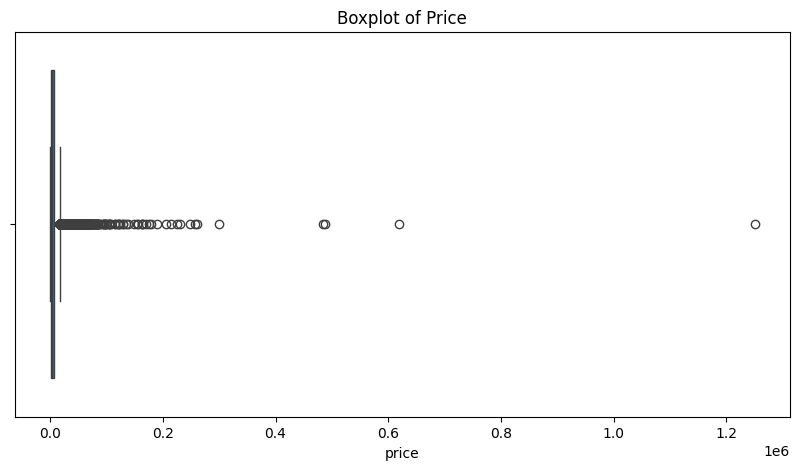

In [396]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['price'])
plt.title('Boxplot of Price')
plt.show()

In [397]:
print("rows after cleaning")
len(df)

rows after cleaning


42892

Creating common believe features for model



In [398]:
df['carAge'] = 2025 - df['yearOfRegistration']

In [399]:
df['carAge'].head(5)

,carAge
0,22
1,20
2,22
3,19
4,17


In [400]:
df['isHighMileage'] = df['kilometer'] > 150000

## Multiple Linear Regression

In [401]:
X = df.drop('price', axis=1)
y = df['price']

Create Dummies and remove multicollinearity by dropping one dummy per group

In [402]:
X = pd.get_dummies(X, drop_first=True)

Train Test split 80-20

In [403]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Train a Multiple Linear Regression Model

In [404]:
from sklearn.linear_model import LinearRegression

# Initialize the model
lr_model = LinearRegression()

# Fit the model to training data
lr_model.fit(X_train, y_train)

LinearRegression()

 Predictions

In [405]:
y_pred = lr_model.predict(X_test)

Evaluation Metrics

In [406]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 3044.11
RMSE: 6546.90
R² Score: 0.5321


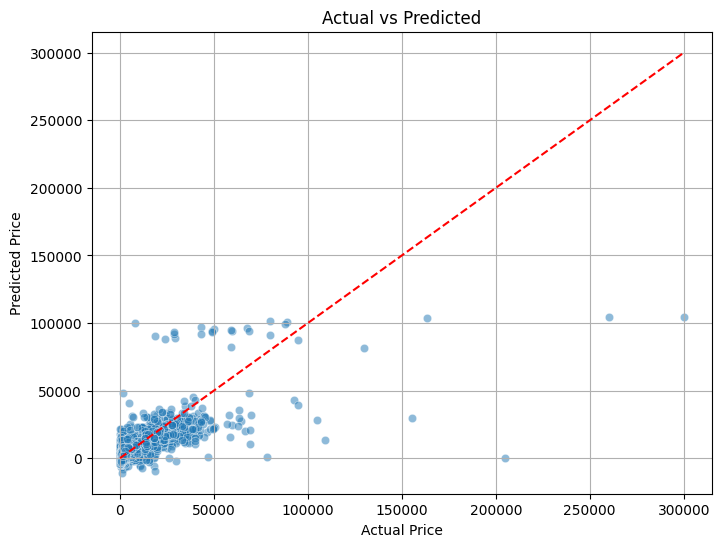

In [407]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

Check Coefficients

In [408]:
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coeff_df.head(10))  # Top 10 positive impact features
print(coeff_df.tail(10))  # Top 10 negative impact features


                     Feature   Coefficient
39                 model_911  69977.405150
124           model_g_klasse  33485.397496
198         model_rangerover  25658.254478
170            model_mustang  24410.686090
292            brand_porsche  22966.728834
159            model_m_reihe  22040.071834
218                 model_sl  19995.334377
128                 model_gl  19833.643434
222             model_spider  18898.772997
197  model_range_rover_sport  17336.912958
                       Feature  Coefficient
264               fuelType_lpg -1220.041407
41                    model_a2 -1299.056346
305  notRepairedDamage_unknown -1315.006879
298                brand_smart -1510.785217
306      notRepairedDamage_yes -1864.566296
254               model_x_type -2022.993388
14              gearbox_manual -2226.353927
207               model_s_type -3516.788738
282                 brand_lada -4296.002213
262           fuelType_electro -9462.090753


Applying Logarithamic

In [409]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

lr_model.fit(X_train, y_train_log)
y_pred_log = lr_model.predict(X_test)

# Convert predictions back
y_pred_actual = np.expm1(y_pred_log)

# Evaluate again
mae = mean_absolute_error(y_test, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_actual))
r2 = r2_score(y_test, y_pred_actual)

print(f"MAE (log model): {mae:.2f}")
print(f"RMSE (log model): {rmse:.2f}")
print(f"R² Score (log model): {r2:.4f}")


MAE (log model): 2588.58
RMSE (log model): 6517.83
R² Score (log model): 0.5362


In [410]:
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("Top +ve features (increase price):")
print(coeff_df)


Top +ve features (increase price):
              Feature  Coefficient
198  model_rangerover     2.819962
170     model_mustang     2.625565
114        model_exeo     2.405203
226      model_superb     2.255708
153        model_leon     2.245259
..                ...          ...
298       brand_smart    -0.897784
294       brand_rover    -0.947443
297       brand_skoda    -0.963361
296        brand_seat    -1.133597
282        brand_lada    -1.236332

[307 rows x 2 columns]


## RandomForestRegressor

In [411]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, np.log1p(y_train))

importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                 Feature    Importance
4                 carAge  4.129488e-01
1                powerPS  2.361327e-01
0     yearOfRegistration  1.071505e-01
2              kilometer  4.561792e-02
3    monthOfRegistration  2.768643e-02
..                   ...           ...
62           model_b_max  8.795520e-08
99           model_croma  7.011339e-08
21             model_200  4.295144e-08
5          isHighMileage  0.000000e+00
168           model_move  0.000000e+00

[307 rows x 2 columns]


In [412]:
# importance_df.to_excel("features_coeff_rf.xlsx", index=False)

In [413]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# View top 20
print(importance_df.head(20))


                       Feature  Importance
4                       carAge    0.412949
1                      powerPS    0.236133
0           yearOfRegistration    0.107150
2                    kilometer    0.045618
3          monthOfRegistration    0.027686
306      notRepairedDamage_yes    0.026984
7           vehicleType_cabrio    0.009571
235          model_transporter    0.008837
305  notRepairedDamage_unknown    0.007214
303           brand_volkswagen    0.006275
6                  abtest_test    0.006168
266            fuelType_petrol    0.005409
12   vehicleType_station wagon    0.004150
39                   model_911    0.004047
14              gearbox_manual    0.003982
9        vehicleType_limousine    0.003743
261            fuelType_diesel    0.003279
290                 brand_opel    0.003108
11       vehicleType_small car    0.003076
286        brand_mercedes_benz    0.003041


Drop noisy features

In [414]:
# Option 1: By threshold
selected_features = importance_df[importance_df['Importance'] >= 0.01]['Feature'].tolist()

# Option 2: Top N features
selected_features = importance_df.head(30)['Feature'].tolist()
print(selected_features)

['carAge', 'powerPS', 'yearOfRegistration', 'kilometer', 'monthOfRegistration', 'notRepairedDamage_yes', 'vehicleType_cabrio', 'model_transporter', 'notRepairedDamage_unknown', 'brand_volkswagen', 'abtest_test', 'fuelType_petrol', 'vehicleType_station wagon', 'model_911', 'gearbox_manual', 'vehicleType_limousine', 'fuelType_diesel', 'brand_opel', 'vehicleType_small car', 'brand_mercedes_benz', 'brand_ford', 'brand_audi', 'model_others', 'model_golf', 'brand_bmw', 'vehicleType_suv', 'vehicleType_coupe', 'brand_porsche', 'brand_renault', 'model_3er']


In [415]:

X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]


In [416]:
# For linear model with log(price)
lr_model.fit(X_train_reduced, np.log1p(y_train))
y_pred_log = lr_model.predict(X_test_reduced)
y_pred = np.expm1(y_pred_log)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


MAE: 2786.70912688286
RMSE: 7947.327065608574
R²: 0.31048347250237984


Random Forest Regressor

In [417]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_reduced, np.log1p(y_train))

y_pred_rf = np.expm1(rf.predict(X_test_reduced))

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²:", r2_score(y_test, y_pred_rf))


MAE: 1595.4124087610728
RMSE: 5551.196908478619
R²: 0.6635846737520701


## xgboost

In [418]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train on log-transformed target
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train_reduced, np.log1p(y_train))

# Predict and convert back
y_pred_xgb = np.expm1(xgb_model.predict(X_test_reduced))

# Evaluate
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 1593.85
RMSE: 4933.36
R² Score: 0.7343


## Hyper parameter Tuning
Cross Validation



In [419]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}


In [420]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import numpy as np

xgb_base = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Use log1p of y_train as before
grid_search.fit(X_train_reduced, np.log1p(y_train))


print("Best Params:", grid_search.best_params_)
print("Best R² Score (CV):", grid_search.best_score_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
Best R² Score (CV): 0.8461841483212321


In [421]:
best_model = grid_search.best_estimator_
y_pred_best = np.expm1(best_model.predict(X_test_reduced))

# Final evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("MAE:", mean_absolute_error(y_test, y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R²:", r2_score(y_test, y_pred_best))


MAE: 1535.492919921875
RMSE: 5007.370567473512
R²: 0.726270318031311


Re-Evaluation

In [422]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


MAE: 1535.49
RMSE: 5007.37
R²: 0.7263


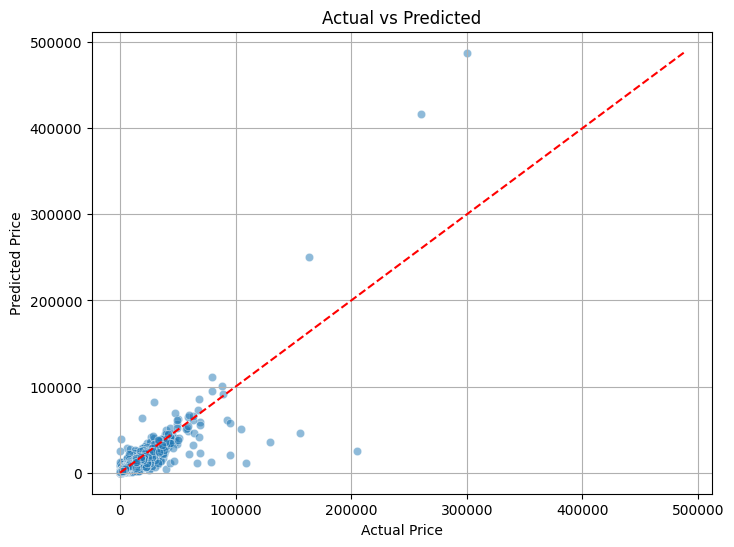

In [423]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_pred_best.max()],
         [y_test.min(), y_pred_best.max()],
         color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

Using SHAP to explain the predictions

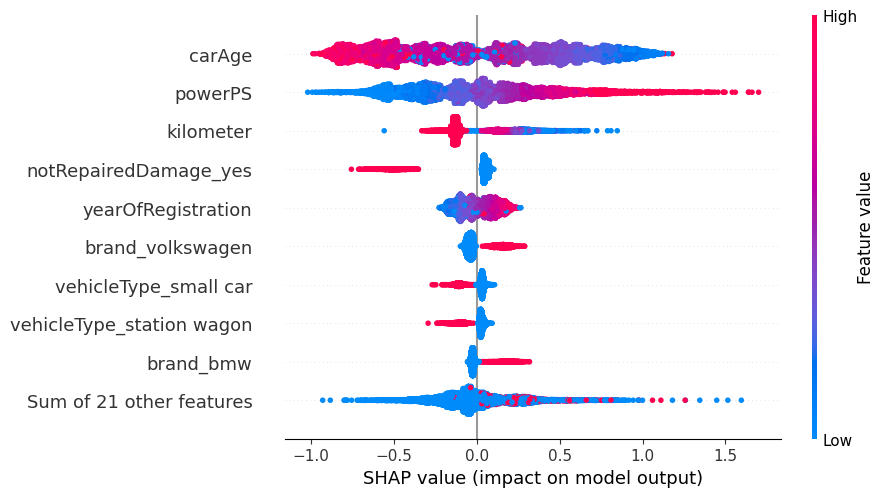

In [424]:
import shap

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_reduced)

shap.plots.beeswarm(shap_values)


Intrepretation:  
Model predicts higher car prices for newer, more powerful, low-mileage cars, especially luxury brands like BMW or Audi, and lower prices for older, high-mileage or damaged cars — exactly what we expect in the real market.

In [425]:
import joblib
joblib.dump(best_model, "car_price_model_xgb_tuned.pkl")


['car_price_model_xgb_tuned.pkl']